<div>
  <img style="float: left;"  width="140" src=" 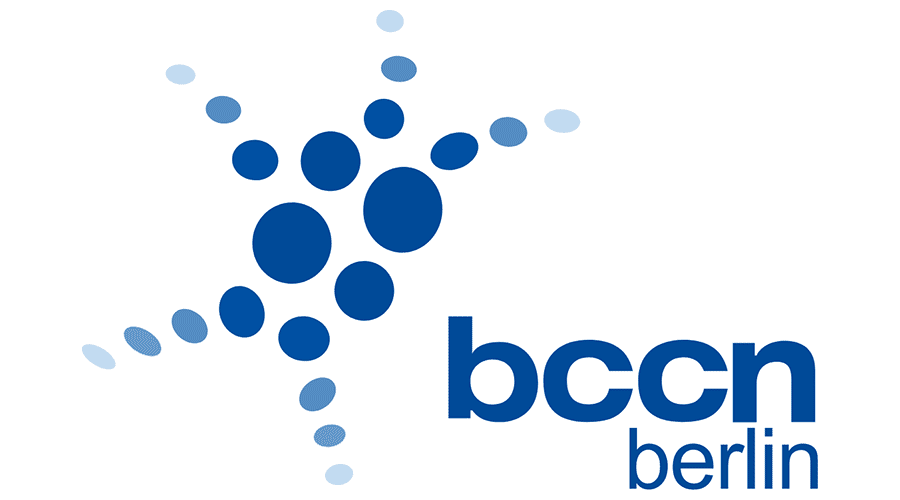">
</div>
 
<h1 id="course-title-heading">
    <div style="text-align: right">
        Models of Higher Brain Functions
        <br>Computer Course
        <br>
    </div>
</h1>
    
---
<div style="text-align: left; float: left">
    Lecturer: Prof. Dr. Henning Sprekeler
</div>

<div style="text-align: right">
    Assistant: Felix Lundt
    <br>(lundt@tu-berlin.de)
</div>



## General exercise instructions
These exercises should be completed entirely in this Jupyter Notebook (comprising source code, discussion and interpretation). Submission should be done through the Moodle interface and should consist only of this notebook (**a single `.ipynb` file**). This Jupyter Notebook was provided inside a `.zip` file, alongside additional files. Do not change the relative paths of these files when working on the assignment (meaning that e.g. `./helper.py` should always be in the same directory as this notebook).

Submission deadline is the start of the next lectue (**10:15 am on Fridays**).

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Some of the exercises will be automatically graded. Make sure that you:
1. Fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE"
2. Remove all `raise NotImplementedError` lines once you inserted your solution
3. Don't use variable names starting with underscore (e.g. `_myvar`) in your code, which could interfere with the automatic grading system.

Before you start, please fill in below your names and the name of your group as shown on Moodle. Example:
```
NAMES = ["Martina Musterfrau", "John Smith"]
GROUP = "A"
```

If you have any questions about the exercises, please ask them **on the Moodle forum** of the course.

In [2]:
NAMES = ["Liam Fogarty", "Ghadi El Hasbani"]
GROUP = "G"

In [3]:
# These are a few tests to make sure that your installed Python software is not too old
import sys
assert sys.version_info.major >= 3, "Your Python version is too old, please update it."

import IPython
assert IPython.version_info[0] >= 3, "Your IPython version is too old, please update it."

---

# Week 7: Reinforcement Learning I

In [4]:
# Necessary imports for this exercise, you can't modify these
import numpy as np
import matplotlib.pyplot as plt

# Import functions defined in the ./helpers.py file
from helpers import assert_var_defined

In [5]:
# You can add your additional package imports here

# Create plots inline in the Jupyter notebook
%matplotlib inline


## Exercise 1: The 10-armed bandit

In this exercise we will maximize the amount of chocolates we can gain by gambling on a chocolate slot machine: the 10-armed bandit.
A 10-armed bandit has 10 levers, each of which has an associated reward probability, i.e. probability of dispensing a chocolate.
In order to maximize the amount of chocolates we can gain, our agent has to find the lever with the highest probability of generating a reward.
The tricky question is: What is a good strategy that balances exploration (trying out different levers) and exploitation (pulling the one we currently think is best)?

All strategies in this exercise rely on a common idea: The agent assigns a so-called $Q$-value $Q(a_{i})$ to each of the possible actions $a_{i}$ (press lever $i$). These $Q$-values represent our current estimate of the reward probability of each action. After pulling lever $i$, we either receive a chocolate or not (reward 1 or 0), and can update the $Q(a_i)$ via

$$
Q(a_i) \leftarrow Q(a_i) + \eta (r - Q(a_i))
$$

where $\eta$ represents a learning rate.

### 1) The training loop

Please make yourself familiar with the following function, the training loop. In the rest of the notebook, we will implement components needed to execute it, and analyze how different rewards and policies affect the agents performance.

In [13]:
def run_episode(generate_reward, policy, num_steps=1000, policy_kwargs=None):
    """ Returns a tuple of (actions, rewards, current q value, maximum q value)"""
    policy_kwargs = policy_kwargs or {}
    q = np.zeros(10)
    info = []
    
    for step in range(num_steps):
        action = policy(step, q, **policy_kwargs)          # Take action based on current step and q values
        reward = generate_reward(action)  # Generate a reward for the taken action
        q = update_q(q, action, reward)   # Update q value of action based on reward

        # Info contains some stuff to plot:
        # the actions, rewards, online q values and offline q values
        info.append((action, reward, q[action], max(q)))
    
    # Some magic to return four lists instead of one list of four-tuples
    return tuple(np.array(i) for i in zip(*info))

### 1 .1) Implement the 10-armed bandit (0.5 points)

Generate an array `p` of 10 random lever reward probabilities $p_{i} \in [0,0.9]$ and **keep it fixed for the entire exercise sheet**.
Additionally, complete the function `generate_reward`, which takes `action` and returns 1 with a probability of `p[action]`, and zero otherwise.

In [6]:
p = np.random.uniform(low=0, high=0.9, size=10)
print(p)

def generate_reward(action):
    return 1 if np.random.random() < p[action] else 0

[0.33962653 0.69427786 0.22287023 0.76714336 0.43169707 0.15415729
 0.72357594 0.10454475 0.03617847 0.28376768]


In [7]:
""" Test that variable `p` is defined """

assert_var_defined("p")
assert_var_defined("generate_reward")

#### 1.1 b) Test your reward function
For each action, generate a reward 10,000 times, and check that the mean reward is close to the expected value (entry in `p`).

In [8]:
rewards = np.zeros((len(p), 10000))
for a in range(len(p)):
    for i in range(10000):
        rewards[a, i] = generate_reward(a)

mean_rewards = np.mean(rewards, axis=1)
mean_rewards

array([0.3491, 0.6843, 0.2229, 0.765 , 0.4301, 0.1528, 0.7287, 0.1033,
       0.0363, 0.2792])

### 1.2) Implement the update of $Q$-values (1 point)

Complete the function `udpate_q`, which updates the $Q$-value of the chosen action according to $Q(a_i) \leftarrow Q(a_i) + \eta (r - Q(a_i))$, where $\eta$ = 0.01.

In [9]:
def update_q(q, action, reward):
    """ q:        np.array,  vector of all q values (shape (10, ))
        action:   int,       chosen action
        reward:   float,     received reward
        returns:  np.array,  the updated vector of q values """
    q[action] += + 0.01*(reward - q[action])
    return q

In [10]:
_q = np.zeros(3)
for _action in range(3):
    for _ in range(10000):
        _q = update_q(_q, _action, 1)

assert np.allclose(_q, np.ones(3))

### 1.3) Implement the *$\epsilon$-greedy* policy (1 point)

The $\epsilon$-greedy policy is a way to choose actions using the current $Q$-values. It balances between eploration and exploitation via the $\epsilon$ parameter:
- With probability $\epsilon$, the agent will choose a random action (sampled uniformly from the action space)
- With probability $1 - \epsilon$, the agent will choose the action with the highest $Q$-value. If there are several actions with the same maximum $Q$-value, the agent chooses a uniformly random one between them.

Write a function `eps_greedy` that implements this strategy.

In [11]:
def epsilon_greedy(step, q, epsilon=0):
    """ step: int,       current step in the episode (you should ignore it here, but we will use it later)
        q: np.array,     current vector of q values
        epsilon: float,  epsilon parameter
        returns: int,    the chosen action
    """
    # YOUR CODE HERE
    flip = np.random.random()
    if flip < epsilon:
        action = np.random.randint(0, len(p))
    else:
        max_q = np.max(q)
        max_indices = np.where(q == max_q)[0]
        if len(max_indices) > 1:
            action = np.random.choice(max_indices)
        else:
            action = max_indices[0]
    return action

### 1.4) Test the $\epsilon$-greedy strategy (2 points)

#### 1.4 a) Test the purely greedy version (1 point)
Run 20 epsiodes, and plot the $Q$-value of the current lever against the trial number in a single plot. Include in the plot a horizontal line representing the maximum reward probability (`max(p)`).

In [12]:
num_episodes = 20

for episode in range(num_episodes):
    result = run_episode(generate_reward, epsilon_greedy)
    plt.plot(range(1000), result[2], label=f'Lever {result[0][-1]}')
plt.axhline(max(p), label='max reward probability', color='r', linestyle='--')
plt.legend()
plt.xlabel('Trial')
plt.ylabel('Q-value')
plt.show()

NameError: name 'run_episode' is not defined

In [13]:
# num_episodes = 20
# num_steps = 1000

# print(p)

# def run_episode(add_labels=False):
#     q = np.zeros((len(p), num_steps))
#     for step in range(1, num_steps):
#         action = epsilon_greedy(step=step, q=q[:, step - 1])
#         reward = generate_reward(action=action)
#         q[:, step] = update_q(q=q[:, step - 1], action=action, reward=reward)
#     for action in range(len(p)):
#         if add_labels:
#             plt.plot(range(num_steps), q[action], label = f'Action {action}')
#         else:
#             plt.plot(range(num_steps), q[action])

# for episode in range(num_episodes):
#     run_episode(add_labels=(episode == 0))

# plt.axhline(max(p), label='max reward probability', color='r', linestyle='--')
# plt.legend()
# plt.show()

#### 1.5 b) Discuss your results (0.5 points)

Does the agent consistently identify the levers with the largest reward probabilities? Explain which levers the agent pulls in the first trials and how this resulst in the behavior you plotted.

Yes, there is a 

### 1.6) Test the $\epsilon$-greedy algorithm

#### 1.6 a) Simulate the algorithm for different $\epsilon$ values (2 points)

Run 100 repetitions ("lives") of the $\epsilon$-greedy strategy (with four different $\epsilon$-values 0.0, 0.01, 0.1 and 0.5) at 1000 iterations each and store the expected reward in each trial. 


Plot the average of the expected reward, and the average largest Q-value across lives against the trial number. Include a line in the plot that runs parallel to the x-axis and represents the maximum expected reward (the maximum reward probability). 

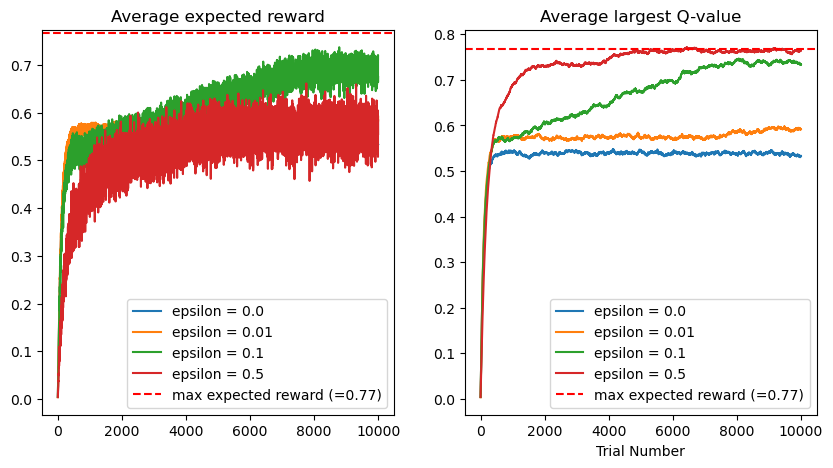

In [64]:
epsilon_vals = [0.0, 0.01, 0.1, 0.5]
num_iterations = 5000
num_lives = 100

def simulate_strategy(num_iterations, num_lives, reward_fn, policy, param_name, param_vals):
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))
    
    for i in range(len(param_vals)):
        expected_rewards = np.zeros((num_lives, num_iterations))
        max_qs = np.zeros((num_lives, num_iterations))
        for life in range(num_lives):
            result = run_episode(reward_fn, policy, num_iterations, {f'{param_name}': param_vals[i]})
            expected_rewards[life, :] = result[2]
            max_qs[life, :] = result[3]
        av_expected_reward = np.mean(expected_rewards, axis=0)
        av_max_q = np.mean(max_qs, axis=0)
        ax[0].plot(range(num_iterations), av_expected_reward, label=f'{param_name} = {param_vals[i]}')
        ax[1].plot(range(num_iterations), av_max_q, label=f'{param_name} = {param_vals[i]}')
    ax[0].set_title('Average expected reward')
    ax[0].axhline(max(p), label=f'max expected reward (={max(p):.2f})', color='r', linestyle='--')
    ax[0].legend()
    ax[1].set_title('Average largest Q-value')
    ax[1].axhline(max(p), label=f'max expected reward (={max(p):.2f})', color='r', linestyle='--')
    ax[1].legend()
    plt.xlabel('Trial Number')
    plt.legend()
    plt.show()

simulate_strategy(num_iterations=10000, num_lives=100, reward_fn=generate_reward, policy=epsilon_greedy, param_name='epsilon', param_vals=epsilon_vals)

#### 1.6b) Discuss your results (2 points)

Why do the expected reward and largest Q-value curves look the way they do for the four cases?

The average expected reward and average maximum Q-value coincide since

### 1.7 Implement a *SoftMax* policy

Finally, we program a *SoftMax* policy: The agent presses the levers with probabilities that depend on the Q-values:

$$
P_{i} = \frac{\exp(\beta Q_i)}{\sum_j\exp(\beta Q_{j})}
$$



#### 1.7a) Write a function that implements the policy (1 point)

Write a function `softmax` that implements this strategy. The function/method should accept as input the current Q and output the lever index(it will always be a single lever index!) that is to be pressed, as well as the maximum Q-value.

In [43]:
def softmax(step, q, beta=1):
    p_vals = (np.exp(beta * q)) / np.sum(np.exp(beta*q))
    return np.random.choice(a=range(len(p)), size=1, p=p_vals)[0]

In [44]:
print(softmax(0,q=np.zeros(10)))

7


#### 1.7 b) Simulate the *SoftMax* strategy for different $\beta$ (1.5 points)

Test this function by running 100 lives with 5000 iterations each and store the expected reward and maximum Q-value in each trial. 

Draw the same curves as in task 1.6 for different values of  $\beta$  = 1, 5, 15, 50.

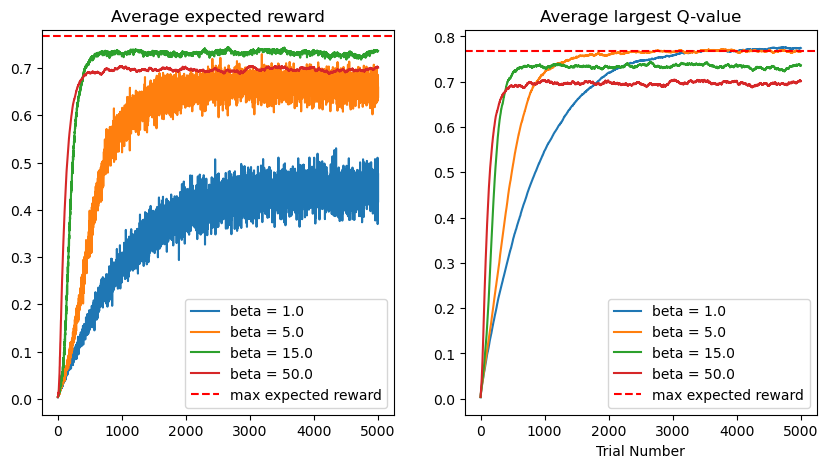

In [45]:
beta_vals = [1., 5., 15., 50.]
num_iterations = 5000
num_lives = 100

simulate_strategy(num_iterations=num_iterations, num_lives=num_lives, reward_fn=generate_reward, policy=softmax, param_name='beta', param_vals=beta_vals)

#### 1.7c) Discuss your results (1 point)

Do the results of SoftMax show any improvements compared to the $\epsilon$-greedy policies? 


Yes,

#### 1.7 d) Explain the $\beta$-parameter (1 point)

How does the parameter $\beta$ relate to the exploration/exploitation-balance? 

#### 1.7 e) Explain your results (1 points)

And once again explain why for each $\beta$ the two curves (expected reward & largest Q-value) look the way they do.

YOUR ANSWER HERE

### 1.8) Add a catastrophic action

#### 1.8 a) Modify your bandit and test your policies (1 point)
Modify the 10-armed bandit so that operating the last lever always gives a reward of -5000 (the agent is punished and has to return 5000 pieces of chocolate). 

Test both the epsilon-greedy and SoftMax policies on this modified bandit (use $\epsilon$ = 0.1, $\beta$ = 15) by running 500 lives with 1000 iterations each and plot the same curve as in task 6.

In [60]:
def generate_reward_catastrophic(action):
    if action == len(p) - 1:
        return -5000
    elif np.random.random() < p[action]:
        return 1
    else:
        return 0

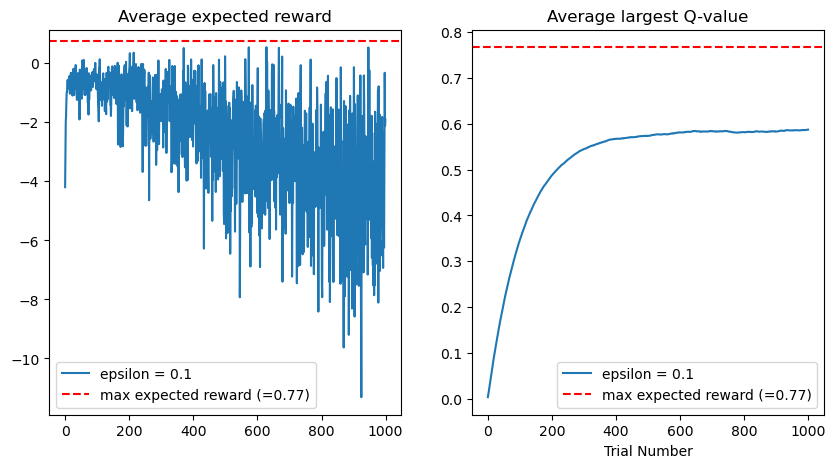

In [66]:
simulate_strategy(
    num_iterations=1000, 
    num_lives=500, 
    reward_fn=generate_reward_catastrophic, 
    policy=epsilon_greedy, 
    param_name='epsilon', 
    param_vals=[0.1])

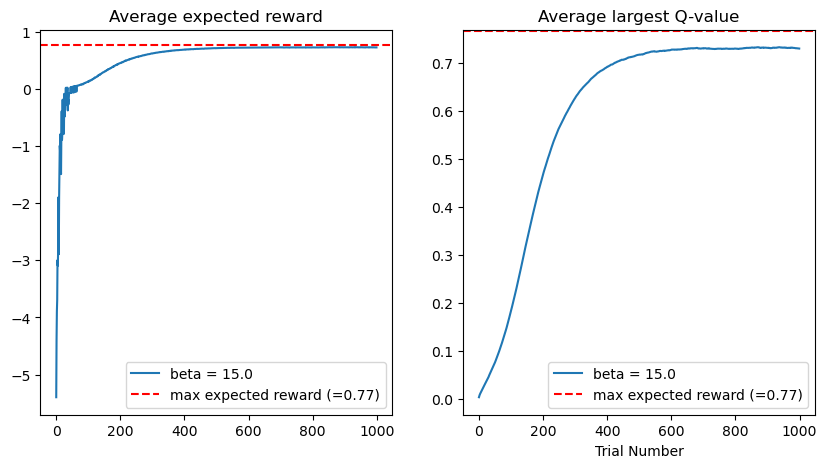

In [67]:
simulate_strategy(
    num_iterations=1000,
    num_lives=500,
    reward_fn=generate_reward_catastrophic,
    policy=softmax,
    param_name='beta',
    param_vals=[15.]
)

#### 1.8 b) Discuss your results (1 point)

Do you observe a difference? Give an intuition for the result! (After this task ditch the punishment and return to the original bandit.)

YOUR ANSWER HERE

### 1.9) Implement a *modified SoftMax* policy with dynamic $\beta$

#### 1.9 a) Implemente the new policy (1 point)

Implement a modified SoftMax policy, where the parameter $\beta$ increases linearly with the number of iterations i starting at a value of 1:

$$
\beta(i) = 1 + \frac{i}{b}
$$

In [65]:
def softmax_linear(step, q, beta=1, b=0.1):
    beta = 1 + step/b
    p_vals = (np.exp(beta * q)) / np.sum(np.exp(beta*q))
    return np.random.choice(a=range(len(p)), size=1, p=p_vals)[0]

#### 1.9 b) Test the policy for different $\beta$-slopes (0.5 points)

Run the simulations with 5 different $\beta$-slopes: b = 0.1, 0.4, 1.6, 6.4, 25.6. and also with the simple SoftMax ($\beta$ = 5).
In each simulation, run 100 lives with 2000 iterations and plot the same curves as in task 6.

How are the plots with different $\beta$-slopes different from the simple SoftMax simulation?


In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

YOUR ANSWER HERE

#### 1.9 c) Plot the cumulative sum of true rewards (0.5)

In a different figure, plot the cumulative sum of true rewards (the sum of rewards until the current trial, aver-
aged over lives) against trial number.

What do you observe?

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

YOUR ANSWER HERE

#### 1.9 d) Plot the cumulative reward against $\beta$-slope (0.5 points)

Furthermore, plot the cumulative reward at the end of the lifetime (2000 iterations) against the $\beta$-slope.

Which of the five slopes generates the maximum overall reward?

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

YOUR ANSWER HERE

#### 1.9 e) Discuss the idea behind using a varying $\beta$ (1 point)

Explain the idea behind using a varying β, in particular regarding the exploration/exploitation dilemma?

Can you think of a similar modification to the  $\epsilon$-greedy policy?

YOUR ANSWER HERE